## Sagnac Frequency - Compare Drift of Rings

## Imports

In [32]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert


In [33]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [34]:
from functions.interpolate_nan import __interpolate_nan

In [35]:
def __get_mlti_intervals(mlti_times):

    from obspy import UTCDateTime
    from numpy import array

    t1, t2 = [], []
    for k,_t in enumerate(mlti_times):

        _t = UTCDateTime(_t)

        if k == 0:
            _tlast = _t
            t1.append(_t)

        if _t -_tlast > 60:
            t2.append(_tlast)
            t1.append(_t)

        _tlast = _t

    t2.append(_t)

    return array(t1), array(t2)

In [36]:
def __load_beat(tbeg, tend, ring, path_to_data):

    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range
    from obspy import UTCDateTime


    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    dd1 = date.fromisoformat(str(tbeg.date))
    dd2 = date.fromisoformat(str(tend.date))

    df = DataFrame()
    for dat in date_range(dd1, dd2):
        file = f"{str(dat)[:4]}/R{ring}/FJ{ring}_"+str(dat)[:10].replace("-", "")+".pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")
    if df.empty:
        print(" -> empty dataframe!")
        return df

    ## trim to defined times
    df = df[(df.times_utc >= tbeg) & (df.times_utc < tend)]

    ## correct seconds
    df['times_utc_sec'] = [abs(tbeg - UTCDateTime(_t))  for _t in df['times_utc']]

    return df

In [37]:
def __smooth(y, npts):

    from numpy import ones, convolve, hanning, nan

    win = hanning(npts)
    y_smooth = convolve(y, win/sum(win), mode='same')

    y_smooth[:npts//2] = nan
    y_smooth[-npts//2:] = nan
    return y_smooth

In [38]:
def __get_mlti_intervals(mlti_times):

    from obspy import UTCDateTime
    from numpy import array

    t1, t2 = [], []
    for k,_t in enumerate(mlti_times):

        _t = UTCDateTime(_t)

        if k == 0:
            _tlast = _t
            t1.append(_t)

        if _t -_tlast > 60:
            t2.append(_tlast)
            t1.append(_t)

        _tlast = _t

    t2.append(_t)

    return array(t1), array(t2)

In [39]:
def __get_mlti_intervals(mlti_times):

    from obspy import UTCDateTime
    from numpy import array

    t1, t2 = [], []
    for k,_t in enumerate(mlti_times):

        _t = UTCDateTime(_t)

        if k == 0:
            _tlast = _t
            t1.append(_t)

        if _t -_tlast > 60:
            t2.append(_tlast)
            t1.append(_t)

        _tlast = _t

    t2.append(_t)

    return array(t1), array(t2)

In [40]:
def __load_mlti(tbeg, tend, ring, path_to_archive):

    from obspy import UTCDateTime
    from pandas import read_csv, concat

    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    rings = {"U":"03", "Z":"01", "V":"02", "W":"04"}

    if tbeg.year == tend.year:
        year = tbeg.year

        path_to_mlti = path_to_archive+f"romy_archive/{year}/BW/CROMY/{year}_romy_{rings[ring]}_mlti.log"

        mlti = read_csv(path_to_mlti, names=["time_utc","Action","ERROR"])

    else:

        path_to_mlti1 = path_to_archive+f"romy_archive/{tbeg.year}/BW/CROMY/{tbeg.year}_romy_{rings[ring]}_mlti.log"
        mlti1 = read_csv(path_to_mlti1, names=["time_utc","Action","ERROR"])

        path_to_mlti2 = path_to_archive+f"romy_archive/{tend.year}/BW/CROMY/{tend.year}_romy_{rings[ring]}_mlti.log"
        mlti2 = read_csv(path_to_mlti2, names=["time_utc","Action","ERROR"])

        mlti = concat([mlti1, mlti2])

    mlti = mlti[(mlti.time_utc > tbeg) & (mlti.time_utc < tend)]

    return mlti

In [41]:
def __mlti_intervals_to_NaN(df_in, mlti_t1, mlti_t2, t_offset_sec=120):

    from numpy import nan, where

    df_in['fj_nan'] = df_in['fj']

    for t1, t2 in zip(mlti_t1, mlti_t2):

        ## trim times to minutes and add t_offset_sec
        tt1, tt2 = str(t1-t_offset_sec)[:16], str(t2+t_offset_sec)[:16]

        ## replace data during mlti times with NaN values
        df_in['fj_nan'] = where((df_in.times_utc > str(tt1)) & (df_in.times_utc < str(tt2)), nan, df_in['fj_nan'])

    return df_in

## Configurations

In [42]:
config = {}

config['tbeg'] = UTCDateTime("2023-12-01 00:00")
config['tend'] = UTCDateTime("2023-12-31 00:00")

config['tbeg'] = UTCDateTime("2024-02-01 00:00")
config['tend'] = UTCDateTime("2024-02-11 00:00")

config['path_to_sds'] = archive_path+"romy_archive/"

## path to Sagnac Beat data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

In [43]:
beatU = __load_beat(config['tbeg'], config['tend'], "U", config['path_to_autodata'])
beatZ = __load_beat(config['tbeg'], config['tend'], "Z", config['path_to_autodata'])
beatV = __load_beat(config['tbeg'], config['tend'], "V", config['path_to_autodata'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


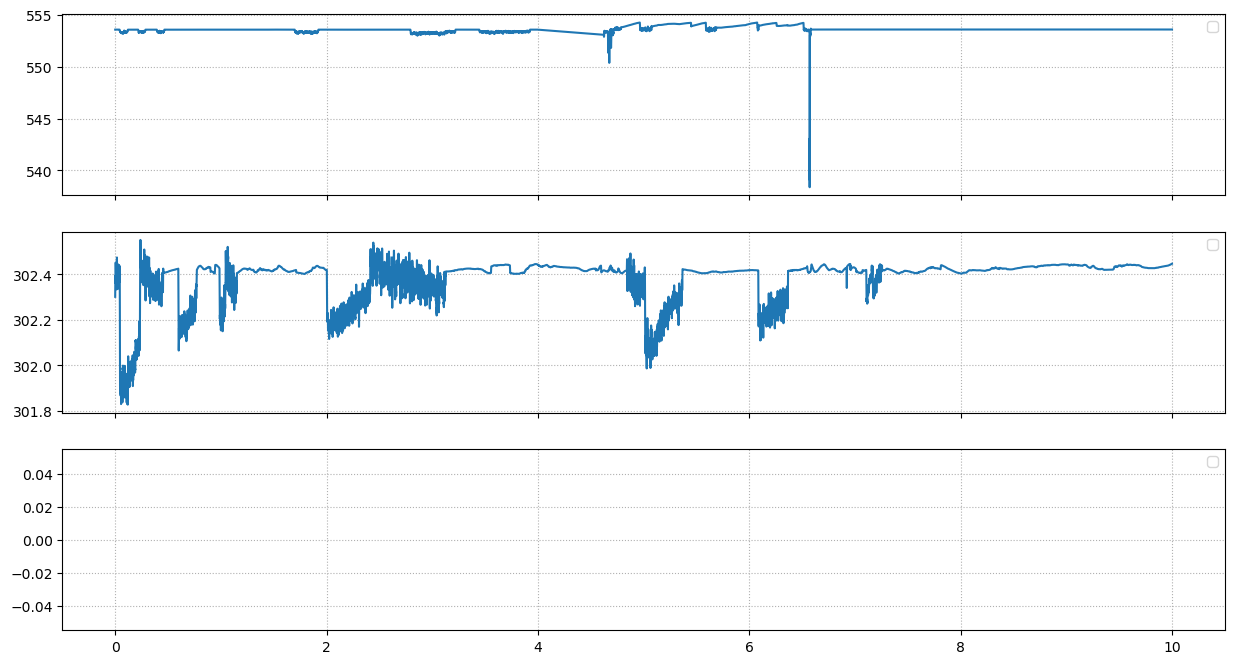

In [44]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    time_scaling = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj)
    # ax[0].set_ylim(553.49, 553.52)
    ax[0].ticklabel_format(useOffset=False)

    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj)
    # ax[1].set_ylim(302.4, 302.5)
    ax[1].ticklabel_format(useOffset=False)

    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj)
    # ax[2].set_ylim(447.4, 447.6)
    ax[2].ticklabel_format(useOffset=False)

    # ax[2].axhline(np.nanpercentile(beatV.fj, 99))
    # ax[2].axhline(np.nanpercentile(beatV.fj, 1))

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    plt.show();
    return fig

fig = __makeplot();


## Remove breakdown periods

In [14]:
times = [("2023-12-04T09:10", "2023-12-04T18:02"),
         ("2023-12-20T06:10", "2023-12-20T12:01")]

for t1, t2 in times:
    beatU['fj'] = np.where((beatU.times_utc > t1) & (beatU.times_utc < t2), np.nan, beatU['fj'])

# beatU['fj'] = np.nan_to_num(beatU['fj'], nan=np.nanmedian(beatU['fj']))

In [15]:
times = [("2024-01-01T04:00", "2024-01-01T22:51"),
         ("2024-01-03T14:20", "2024-01-06T00:00"),
         ("2023-12-19T09:40", "2023-12-19T15:21")]

for t1, t2 in times:
    beatV['fj'] = np.where((beatV.times_utc > t1) & (beatV.times_utc < t2), np.nan, beatV['fj'])

# beatV['fj'] = np.nan_to_num(beatV['fj'], nan=np.nanmedian(beatV['fj']))

In [16]:
times = [("2023-12-07T00:10", "2023-12-08T18:05")]

for t1, t2 in times:
    beatZ['fj'] = np.where((beatZ.times_utc > t1) & (beatZ.times_utc < t2), np.nan, beatZ['fj'])

# beatZ['fj'] = np.nan_to_num(beatZ['fj'], nan=np.nanmedian(beatZ['fj']))

In [17]:
# beatU['fj'] = np.where((beatU.times_utc < "2023-12-20T07:00:30") & (beatU.fj < 302.4), np.nan, beatU.fj)
beatU['fj'] = np.where((beatU.fj < 302.4), np.nan, beatU.fj)

## cut off outliers manually
beatU['fj'] = np.where((beatU.times_utc > "2023-12-18T20:40") & (beatU.times_utc < "2023-12-19T05:00") & (beatU.fj < 302.48), np.nan, beatU.fj)


In [18]:
beatZ['fj'] = np.where((beatZ.fj > 553.515), np.nan, beatZ.fj)

In [19]:
# i1, i2 = 25000, 25500

# # print(beatZ.times_utc.iloc[i1], beatZ.times_utc.iloc[i2])
# # plt.plot(beatZ.times_utc_sec.iloc[i1:i2], beatZ.fj.iloc[i1:i2])

# print(beatU.times_utc.iloc[i1], beatU.times_utc.iloc[i2])
# plt.plot(beatU.times_utc_sec.iloc[i1:i2], beatU.fj.iloc[i1:i2])
# # plt.plot(beatU.times_utc_sec.iloc[i1:i2], beatU.fj_nan.iloc[i1:i2])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


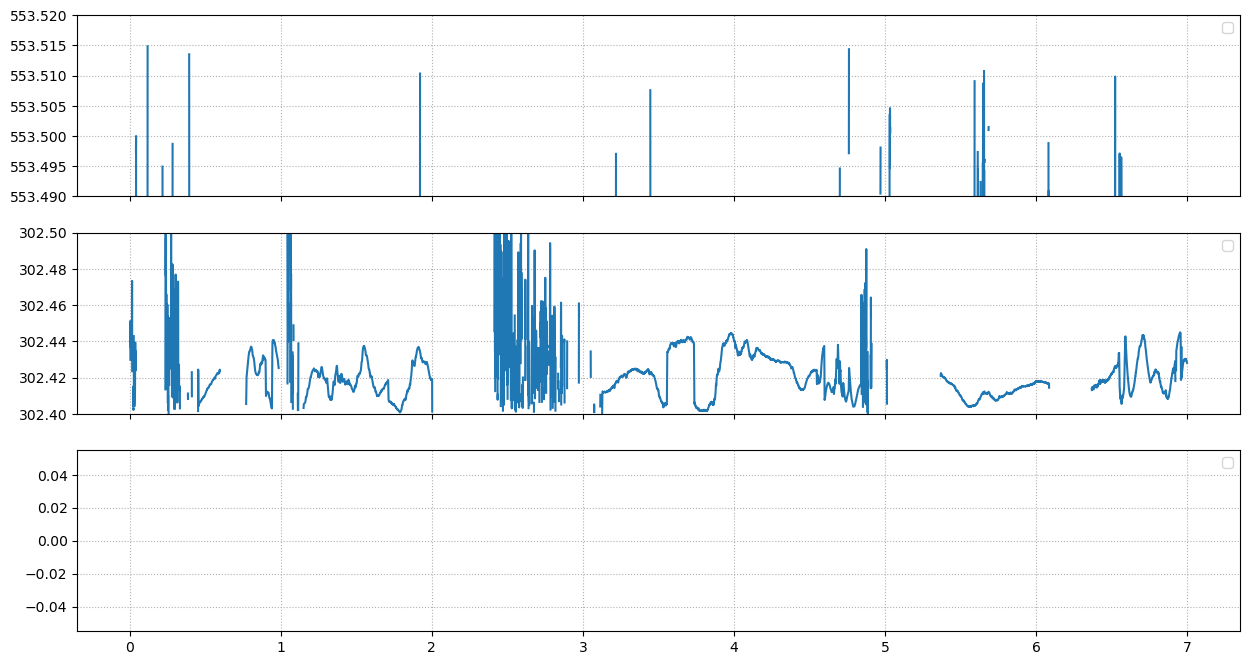

In [20]:
fig = __makeplot();

## Remove MLTI times

In [21]:
mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

In [22]:
mltiZ = __load_mlti(config['tbeg'], config['tend'], "Z", archive_path)

In [23]:
mltiV = __load_mlti(config['tbeg'], config['tend'], "V", archive_path)

In [24]:
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [25]:
mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

In [26]:
mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)

In [27]:
# # df, mlti, mlti_t1, mlti_t2  = beatU, mltiU, mltiU_t1, mltiU_t2
# # df, mlti, mlti_t1, mlti_t2  = beatV, mltiV, mltiV_t1, mltiV_t2
# df, mlti, mlti_t1, mlti_t2  = beatZ, mltiZ, mltiZ_t1, mltiZ_t2


# time_axis = df.times_utc_sec-df.times_utc_sec.iloc[0]
# plt.plot(time_axis, df.fj, zorder=2)

# # for m in mlti.time_utc:
# #     plt.axvline((UTCDateTime(m)-config['tbeg'])/86400, color="red", zorder=0, alpha=0.5)

# miny, maxy = min(df.fj), max(df.fj)
# for t1, t2 in zip(mlti_t1, mlti_t2):
#     plt.fill_betweenx([miny, maxy], t1-config['tbeg'], t2-config['tbeg'], color="red", alpha=0.5;

In [28]:
# i1, i2 = 20400, 26819

# print(beatV.times_utc.iloc[i1], beatV.times_utc.iloc[i2])
# plt.plot(beatV.times_utc_sec.iloc[i1:i2], beatV.fj.iloc[i1:i2])

In [29]:
beatU = __mlti_intervals_to_NaN(beatU, mltiU_t1, mltiU_t2, t_offset_sec=180)
beatV = __mlti_intervals_to_NaN(beatV, mltiV_t1, mltiV_t2, t_offset_sec=180)
beatZ = __mlti_intervals_to_NaN(beatZ, mltiZ_t1, mltiZ_t2, t_offset_sec=180)

## Interpolate NaN values

In [30]:
beatU['fj_inter'] = __interpolate_nan(np.array(beatU.fj_nan))
beatV['fj_inter'] = __interpolate_nan(np.array(beatV.fj_nan))
beatZ['fj_inter'] = __interpolate_nan(np.array(beatZ.fj_nan))

ValueError: array of sample points is empty

## Smoothing

In [ ]:
n_minutes = 600

beatU['fj_smooth'] = __smooth(beatU.fj_inter, n_minutes)
beatV['fj_smooth'] = __smooth(beatV.fj_inter, n_minutes)
beatZ['fj_smooth'] = __smooth(beatZ.fj_inter, n_minutes)

## Plotting

In [ ]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    # time_scaling = 1/86400
    time_scaling = 1

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_inter, color="tab:blue", label="cleaned")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[0].set_ylim(553.49, 553.51)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("Horizontal ring (Hz)", fontsize=font)

    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_inter, color="tab:green", label="cleaned")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[1].set_ylim(302.4, 302.52)
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel("Northern ring (Hz)", fontsize=font)

    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_inter, color="tab:red", label="cleaned")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[2].set_ylim(447.435, 447.455)
    ax[2].ticklabel_format(useOffset=False)
    ax[2].set_ylabel("Western ring (Hz)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)
        # ax[_n].set_xlim(left=0)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    ## add dates to x-axis
    ref_date = UTCDateTime(beatZ.times_utc.iloc[0][:10])
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BeatDrift_smoothed.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
beatU['fj_reduced'] = beatU['fj_smooth'] - np.abs(np.nanmean(beatU['fj_smooth'].iloc[:500]))
beatV['fj_reduced'] = beatV['fj_smooth'] - np.abs(np.nanmean(beatV['fj_smooth'].iloc[:500]))
beatZ['fj_reduced'] = beatZ['fj_smooth'] - np.abs(np.nanmean(beatZ['fj_smooth'].iloc[:500]))

In [ ]:
def __sagnac_to_tilt(data, ring):

    from numpy import pi, sqrt, arccos, deg2rad, arcsin

    dip = {"Z":0, "U":109.5, "V":70.5, "W":70.5}

    L = {"Z":11.2, "U":12, "V":12, "W":12}

    ## Scale factor
    S = (sqrt(3)*L[ring])/(3*632.8e-9)

    ## ROMY latitude
    lat = 48.162941

    ## nominal Earth rotation
    omegaE = 2*pi/86400

    return arcsin(data /omegaE /S) - deg2rad(lat) - deg2rad(dip[ring])

In [ ]:
beatZ['tilt'] = __sagnac_to_tilt(beatZ['fj_reduced'], "Z")
beatU['tilt'] = __sagnac_to_tilt(beatU['fj_reduced'], "U")
beatV['tilt'] = __sagnac_to_tilt(beatV['fj_reduced'], "V")

beatU['tilt_reduced'] = beatU.tilt - np.nanmean(beatU.tilt.iloc[:1440])
beatV['tilt_reduced'] = beatV.tilt - np.nanmean(beatV.tilt.iloc[:1440])
beatZ['tilt_reduced'] = beatZ.tilt - np.nanmean(beatZ.tilt.iloc[:1440])

In [ ]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    time_scaling = 1/86400
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_reduced, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    ax[0].plot(beatU.times_utc_sec*time_scaling, beatU.fj_reduced, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta f$ (Hz)", fontsize=font)

    ax[1].plot(beatZ.times_utc_sec*time_scaling, beatZ.tilt_reduced*tilt_scaling, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[1].plot(beatV.times_utc_sec*time_scaling, beatV.tilt_reduced*tilt_scaling, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.tilt_reduced*tilt_scaling, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")


    ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylim(-0.04, 0.07)

    ## add dates to x-axis
    ref_date = UTCDateTime(beatZ.times_utc.iloc[0][:10])
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

# fig = __makeplot();


## Rotate to ZNE

In [ ]:
tr_beatU = Trace()
tr_beatU.data = np.array(beatU.fj_reduced)
tr_beatU.stats.delta = 60
tr_beatU.stats.starttime = UTCDateTime(str(beatU.times_utc.iloc[0]))
tr_beatU.stats.network, tr_beatU.stats.station, tr_beatU.stats.channel = "BW", "ROMY", "LJU"
# tr_beatU.plot();

tr_beatV = Trace()
tr_beatV.data = np.array(beatV.fj_reduced)
tr_beatV.stats.delta = 60
tr_beatV.stats.starttime = UTCDateTime(str(beatV.times_utc.iloc[0]))
tr_beatV.stats.network, tr_beatV.stats.station, tr_beatV.stats.channel = "BW", "ROMY", "LJV"
# tr_beatV.plot();

tr_beatZ = Trace()
tr_beatZ.data = np.array(beatZ.fj_reduced)
tr_beatZ.stats.delta = 60
tr_beatZ.stats.starttime = UTCDateTime(str(beatZ.times_utc.iloc[0]))
tr_beatZ.stats.network, tr_beatZ.stats.station, tr_beatZ.stats.channel = "BW", "ROMY", "LJZ"
# tr_beatZ.plot();

st_beat = Stream(traces=[tr_beatU, tr_beatV, tr_beatZ])

etime = min(st_beat[0].stats.endtime, st_beat[1].stats.endtime, st_beat[2].stats.endtime)
st_beat = st_beat.trim(st_beat[0].stats.starttime, etime)

st_beat

In [ ]:
from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE

In [ ]:
config['path_to_inventory'] = root_path+"Documents/ROMY/stationxml_ringlaser/dataless/"

romy_inv = read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")

st_beat_zne = __rotate_romy_ZUV_ZNE(st_beat, romy_inv)

# st_beat_zne.plot();

In [ ]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    ref_date = UTCDateTime(beatZ.times_utc.iloc[0][:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_reduced, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    ax[0].plot(beatU.times_utc_sec*time_scaling, beatU.fj_reduced, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta f$ (Hz)", fontsize=font)


    # ax[1].plot(beatZ.times_utc_sec*time_scaling, beatZ.tilt_reduced*tilt_scaling, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    # ax[1].plot(beatV.times_utc_sec*time_scaling, beatV.tilt_reduced*tilt_scaling, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    # ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.tilt_reduced*tilt_scaling, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[1].plot(st_beat.select(channel="*Z")[0].times(reftime=ref_date),
               st_beat.select(channel="*Z")[0].data,
               color="black", label=f"RZ (mov. avg. {n_minutes} min)")

    ax[1].plot(st_beat_zne.select(channel="*Z")[0].times(reftime=ref_date),
               st_beat_zne.select(channel="*Z")[0].data,
               color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)", ls="--")
    ax[1].plot(st_beat_zne.select(channel="*N")[0].times(reftime=ref_date),
               st_beat_zne.select(channel="*N")[0].data,
               color="tab:green", label=f"RN (mov. avg. {n_minutes} min)", ls="--")
    ax[1].plot(st_beat_zne.select(channel="*E")[0].times(reftime=ref_date),
               st_beat_zne.select(channel="*E")[0].data,
               color="tab:red", label=f"RE (mov. avg. {n_minutes} min)", ls="--")


    # ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
    ax[1].set_ylabel("$\Delta f$ (Hz)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylim(-0.07, 0.07)
    ax[0].set_ylim(-0.07, 0.07)

    ## add dates to x-axis
    ref_date = UTCDateTime(beatZ.times_utc.iloc[0][:10])
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BeatDrift_smoothed_ZNE.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
def __sagnac_to_rads(data, ring):

    from numpy import pi, sqrt, arccos, deg2rad, sin

    dip = {"Z":0, "U":109.5, "V":70.5, "W":70.5}

    L = {"Z":11.2, "U":12, "V":12, "W":12}

    ## Scale factor
    S = (sqrt(3)*L[ring])/(3*632.8e-9)

    ## ROMY latitude
    lat = 48.162941

    ## nominal Earth rotation
    omegaE = 2*pi/86400

    return data /S /sin(deg2rad(lat+dip[ring]))

In [ ]:

st_rad = st_beat.copy()

for tr in st_rad:
    tr.data = __sagnac_to_rads(tr.data, tr.stats.channel[-1])
    tr.data = __interpolate_nan(tr.data)

st_rad = st_rad.integrate(method='cumtrapz')

st_rad = __rotate_romy_ZUV_ZNE(st_rad, romy_inv)

# st_rad.plot(equal_scale=False)

In [ ]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    ref_date = UTCDateTime(beatZ.times_utc.iloc[0][:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(st_beat.select(channel="*Z")[0].times()*time_scaling,
               st_beat.select(channel="*Z")[0].data,
               color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[0].plot(st_beat.select(channel="*V")[0].times()*time_scaling,
               st_beat.select(channel="*V")[0].data,
               color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    ax[0].plot(st_beat.select(channel="*U")[0].times()*time_scaling,
               st_beat.select(channel="*U")[0].data,
               color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta$f (Hz)", fontsize=font)


    ax[1].plot(st_rad.select(channel="*Z")[0].times()*time_scaling,
               st_rad.select(channel="*Z")[0].data*tilt_scaling,
               color="tab:blue", label=f"RZ")
    ax[1].plot(st_rad.select(channel="*N")[0].times()*time_scaling,
               st_rad.select(channel="*N")[0].data*tilt_scaling,
               color="tab:red", label=f"RN ")
    ax[1].plot(st_rad.select(channel="*E")[0].times()*time_scaling,
               st_rad.select(channel="*E")[0].data*tilt_scaling,
               color="tab:green", label=f"RE")


    ax[1].set_ylabel("$\Delta f$ (Hz)", fontsize=font)
    ax[1].set_ylabel("Tilt ($\mu$rad)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylim(-0.07, 0.07)
    ax[0].set_ylim(-0.07, 0.07)

    ## add dates to x-axis
    ref_date = UTCDateTime(beatZ.times_utc.iloc[0][:10])
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BeatDrift_smoothed_asTilt.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
st_rad

In [ ]:
def __get_vector_movement(N, E, Twin=3600, ref_date=None, plot=False):

    from numpy import median, sqrt, arctan, degrees, mod, array, append, rad2deg, nan, ma, deg2rad

    dt = N[0].stats.delta
    t1 = 0

    Ndata = N[0].data
    Edata = E[0].data

    if ma.is_masked(Ndata):
        Ndata = ma.filled(Ndata, fill_value=nan)
    if ma.is_masked(Edata):
        Edata = ma.filled(Edata, fill_value=nan)

    vnorm, vdir, timeline = [], [], []
    while (t1 + Twin) < N[0].stats.npts*dt:

        Nmed = median(Ndata[int(t1/dt):int((t1+Twin)/dt)])
        Emed = median(Edata[int(t1/dt):int((t1+Twin)/dt)])


        vnorm.append(sqrt(Nmed**2 + Emed**2))

        if Nmed > 0 and Emed > 0:
            vdir.append(90-abs(rad2deg(arctan(abs(Nmed/Emed)))))

        elif Nmed < 0 and Emed > 0:
            vdir.append(90+abs(rad2deg(arctan(abs(Nmed/Emed)))))

        elif Nmed < 0 and Emed < 0:
            vdir.append(270-abs(rad2deg(arctan(abs(Nmed/Emed)))))

        elif Nmed > 0 and Emed < 0:
            vdir.append(270+abs(rad2deg(arctan(abs(Nmed/Emed)))))

        else:
            vdir.append(nan)

        t1 += Twin/2

        timeline.append(t1)

    if ref_date:
        time_offset = abs(UTCDateTime(ref_date) - N[0].stats.starttime)
    else:
        time_offset = 0

    vnorm = array(vnorm)
    vdir = array(vdir)
    timeline = (array(timeline) + time_offset)/3600 ## in hours


    ## Plotting ------------------------------------
    if plot:

        from numpy import deg2rad, arange, linspace
        import matplotlib.pyplot as plt

        vnorm = vnorm
        vdirection = vdir

        ## times to days
        times = timeline /24

        time_min = min(times)
        time_max = max(times)

        ## Plot --------------------------------------------------------------------------
        fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'), figsize=(5, 5))

        font = 12

        cmap = plt.get_cmap('viridis')

        vscaling, vunit = 1e3, "mrad"

        ## convert degrees to radians for plotting as polar!
        p0 = ax.scatter(deg2rad(vdirection), vnorm*vscaling, c=times, cmap=cmap,
                        vmin=time_min, vmax=time_max, alpha=0.75, s=4, zorder=2)

        cbar = plt.colorbar(p0, ax=ax,  pad=0.1, orientation='vertical', fraction=0.1, shrink=.8)

        if ref_date:
            cbar.set_label('Time (days)', rotation=90, fontsize=font, labelpad=10)
        else:
            cbar.set_label(f'Time from {ref_date} (days)', rotation=90, fontsize=font, labelpad=10)

        ## set new colorbar ticks
        # ref_time = config['tbeg']
        # nticks = [str((ref_time+time_min+t*86400).date) for t in cbar.get_ticks()]
        # cbar.set_ticklabels(nticks)

        vmax = round(max(vnorm*vscaling) * 1.1, 0)

        ax.set_ylim(0, vmax)
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)

        ax.text(deg2rad(25), vmax*1.2, f"({vunit})")
        ax.set_rgrids(linspace(0., vmax, 5), angle=25., zorder=0)

        ax.set_title("Tilt of ROMY structure", fontsize=font)

        plt.show();

    return timeline, vdir, vnorm

In [ ]:
def __makeplot_normal_vector_movement(times, vdirection, vnorm, ref_date=None):

    from numpy import deg2rad, arange, linspace
    import matplotlib.pyplot as plt

    ## times to days
    times = times /24

    time_min = min(times)
    time_max = max(times)

    ## Plot --------------------------------------------------------------------------
    fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'), figsize=(5, 5))

    font = 12

    cmap = plt.get_cmap('viridis')

    vscaling, vunit = 1e3, "mrad"

    ## convert degrees to radians for plotting as polar!
    p0 = ax.scatter(deg2rad(vdirection), vnorm*vscaling, c=times, cmap=cmap,
                    vmin=time_min, vmax=time_max, alpha=0.75, s=4, zorder=2)

    cbar = plt.colorbar(p0, ax=ax,  pad=0.1, orientation='vertical', fraction=0.1, shrink=.8)

    if ref_date is not None:
        cbar.set_label('Time (days)', rotation=90, fontsize=font, labelpad=10)
    else:
        cbar.set_label(f'Time from {ref_date} (days)', rotation=90, fontsize=font, labelpad=10)

    ## set new colorbar ticks
    # ref_time = config['tbeg']
    # nticks = [str((ref_time+time_min+t*86400).date) for t in cbar.get_ticks()]
    # cbar.set_ticklabels(nticks)

    vmax = round(max(vnorm*vscaling) * 1.1, 0)

    ax.set_ylim(0, vmax)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    ax.text(deg2rad(25), vmax*1.2, f"({vunit})")
    ax.set_rgrids(linspace(0., vmax, 5), angle=25., zorder=0)

    ax.set_title("Tilt of ROMY structure", fontsize=font)

    plt.show();
    return fig

In [ ]:
twindow = 3600  ## seconds

ttimes, vector_direction, vector_norm = __get_vector_movement(st_rad.select(channel="*N"),
                                                              st_rad.select(channel="*E"),
                                                              Twin=twindow,
                                                              plot=False,
                                                              )


In [ ]:

fig = __makeplot_normal_vector_movement(ttimes, vector_direction, vector_norm, ref_date=st_rad[0].stats.starttime.date)

fig.savefig(config['path_to_figs']+f"BeatDrift_vector_movement.png", format="png", dpi=150, bbox_inches='tight')


## Tides

In [ ]:
st_beat_zne_tide = st_beat_zne.copy();

for tr in st_beat_zne_tide:
    tr.data = __interpolate_nan(tr.data)

## daily
# f1 = 1/(25*3600)
# f2 = 1/(23*3600)

## sub-daily
f1 = 1/(13*3600)
f2 = 1/(11*3600)

# st_beat_zne_tide.detrend("linear")
# st_beat_zne_tide.taper(0.2)
st_beat_zne_tide.filter("bandpass", freqmin=f1, freqmax=f2, corners=4, zerophase=True)

st_beat_zne_tide.plot(equal_scale=False);


### Load Tilt Data

In [ ]:
from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from functions.conversion_to_tilt import __conversion_to_tilt

In [ ]:
path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"

sta = "TROMY"

tilt =  __read_sds(path_to_tilt, f"BW.{sta}..MAT", config['tbeg']-600, config['tend']+600)
tilt += __read_sds(path_to_tilt, f"BW.{sta}..MAN", config['tbeg']-600, config['tend']+600)
tilt += __read_sds(path_to_tilt, f"BW.{sta}..MAE", config['tbeg']-600, config['tend']+600)

## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tilt = __conversion_to_tilt(tilt, confTilt[f'{sta}'])

tilt = tilt.trim(config['tbeg'], config['tend'])

tilt.plot(equal_scale=False);

gc.collect();

In [ ]:
tides = Stream()

tides += st_rad.copy()
tides += tilt.copy()

tides = tides.resample(0.005, no_filter=False);

# f1, f2 = 1/(15*3600), 1/(11*3600)
# f1, f2 = 1/(25*3600), 1/(23*3600)

# tides = tides.detrend("simple")
# tides = tides.taper(0.01)
# tides = tides.filter("bandpass", freqmin=f1, freqmax=f2, corners=4, zerophase=True)

# tides.merge();

tides.plot(equal_scale=False);

In [ ]:
def __makeplot_tides():


    f1_subdaily, f2_subdaily = 1/(13*3600), 1/(11*3600)

    f1_daily, f2_daily = 1/(25*3600), 1/(23*3600)

    _detrend="simple"
    _taper = 0.05
    corners = 2

    tiltmeter="TROMY"

    tides_daily = tides.copy()
    tides_daily = tides_daily.detrend(_detrend)
    tides_daily = tides_daily.taper(_taper, type="cosine")
    tides_daily = tides_daily.filter("bandpass", freqmin=f1_daily, freqmax=f2_daily, corners=corners, zerophase=False)
    # tides_daily = tides_daily.filter("bandpass", freqmin=f1_daily, freqmax=f2_daily, corners=corners, zerophase=True)

    tides_subdaily = tides.copy()
    tides_subdaily = tides_subdaily.detrend(_detrend)
    tides_subdaily = tides_subdaily.taper(_taper, type="cosine")
    tides_subdaily = tides_subdaily.filter("bandpass", freqmin=f1_subdaily, freqmax=f2_subdaily, corners=corners, zerophase=False)
    # tides_subdaily = tides_subdaily.filter("bandpass", freqmin=f1_subdaily, freqmax=f2_subdaily, corners=corners, zerophase=True)


    Nrow, Ncol = 2, 2

    font = 12

    time_scaling, time_unit = 1/86400, "days"
    tilt_scaling, tilt_unit = 1e9, "nrad"

    ref_time = config['tbeg']-86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0,0].plot(tides_subdaily.select(station=tiltmeter, channel="*N")[0].times(reftime=ref_time)*time_scaling,
                 tides_subdaily.select(station=tiltmeter, channel="*N")[0].data*tilt_scaling,
                 color="black", label=f"N-S {tiltmeter}", lw=1)

    ax[1,0].plot(tides_subdaily.select(station=tiltmeter, channel="*E")[0].times(reftime=ref_time)*time_scaling,
                 tides_subdaily.select(station=tiltmeter, channel="*E")[0].data*tilt_scaling,
                 color="black", label=f"E-W {tiltmeter}", lw=1)

    ax[0,1].plot(tides_daily.select(station=tiltmeter, channel="*N")[0].times(reftime=ref_time)*time_scaling,
                 tides_daily.select(station=tiltmeter, channel="*N")[0].data*tilt_scaling,
                 color="black", label=f"N-S {tiltmeter}", lw=1)

    ax[1,1].plot(tides_daily.select(station=tiltmeter, channel="*E")[0].times(reftime=ref_time)*time_scaling,
                 tides_daily.select(station=tiltmeter, channel="*E")[0].data*tilt_scaling,
                 color="black", label=f"E-W {tiltmeter}", lw=1)

    ax00 = ax[0,0].twinx()
    ax10 = ax[1,0].twinx()
    ax01 = ax[0,1].twinx()
    ax11 = ax[1,1].twinx()


    ax00.plot(tides_subdaily.select(station="ROMY", channel="*N")[0].times(reftime=ref_time)*time_scaling,
                 tides_subdaily.select(station="ROMY", channel="*N")[0].data*tilt_scaling,
                 color="darkred", label="N-S (ring)", lw=1)

    ax10.plot(tides_subdaily.select(station="ROMY", channel="*E")[0].times(reftime=ref_time)*time_scaling,
                 tides_subdaily.select(station="ROMY", channel="*E")[0].data*tilt_scaling,
                 color="darkred", label="E-W (ring)", lw=1)

    ax01.plot(tides_daily.select(station="ROMY", channel="*N")[0].times(reftime=ref_time)*time_scaling,
                 tides_daily.select(station="ROMY", channel="*N")[0].data*tilt_scaling,
                 color="darkred", label="N-S (ring)", lw=1)

    ax11.plot(tides_daily.select(station="ROMY", channel="*E")[0].times(reftime=ref_time)*time_scaling,
                 tides_daily.select(station="ROMY", channel="*E")[0].data*tilt_scaling,
                 color="darkred", label="E-W (ring)", lw=1)


    ax[0,0].set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)
    ax[1,0].set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)
    ax01.set_ylabel(f"Tilt ({tilt_unit})", fontsize=font, color="darkred")
    ax11.set_ylabel(f"Tilt ({tilt_unit})", fontsize=font, color="darkred")

    ax[1,0].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)
    ax[1,1].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)

    ax[0,0].set_ylim(-60, 60)
    ax[0,1].set_ylim(-40, 40)
    ax[1,0].set_ylim(-100, 100)
    ax[1,1].set_ylim(-50, 50)

    ax[0,0].set_title(f"T={round(1/f2_subdaily/3600,1)} - {round(1/f1_subdaily/3600,1)}h", fontsize=font+1)
    ax[0,1].set_title(f"T={round(1/f2_daily/3600,1)} - {round(1/f1_daily/3600,1)}h", fontsize=font+1)

    ticks = []
    for _i in range(Nrow):
        for _j in range(Ncol):
            ax[_i,_j].grid(ls=":", zorder=0)
            ax[_i,_j].legend(loc=1)
            ticks.append(ax[_i,_j].get_yticks())


    for ax in [ax00, ax10, ax01, ax11]:
        ax.tick_params(axis='y', colors='darkred')
        ax.legend(loc=4)

    ax00.set_yticks(np.linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ticks[0])))
    ax10.set_yticks(np.linspace(ax10.get_yticks()[0], ax10.get_yticks()[-1], len(ticks[2])))
    ax01.set_yticks(np.linspace(ax01.get_yticks()[0], ax01.get_yticks()[-1], len(ticks[1])))
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ticks[3])))


#     ## add dates to x-axis
#     ref_date = UTCDateTime(config['tbeg'])
#     tcks = ax[Nrow-1].get_xticks()
#     tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
#     ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot_tides();

